In [2]:
import torch

In [3]:
from model import SpectralSSM
from model import SpectralSSMConfigs
d_in=  24
d_out = 18
sl = 512

n_layers: int = 4
d_model: int = 32
embd_scale: int = 1
mlp_scale: int = 4
bias: bool = False
dropout: float = 0.0
num_eigh: int = 16
k_y: int = 2
k_u: int = 3
learnable_m_y: bool = False
alpha: float = 0.9  # 0.9 deemed "uniformly optimal" in the paper
use_ar_y: bool = False
use_ar_u: bool = False
use_hankel_L: bool = False
use_flash_fft: bool = False
use_approx: bool = True

# MoE
moe: bool = False
num_experts: int = 3
num_experts_per_timestep: int = 2

#residual
num_models= 2

In [4]:
from losses.loss_walker import Walker2DLoss
loss_fn= Walker2DLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

configs = SpectralSSMConfigs(
        n_layers=n_layers,
        d_model=d_model,
        d_in=d_in,
        d_out=d_out,
        sl=sl,
        mlp_scale=mlp_scale,
        embd_scale=embd_scale,
        bias=bias,
        dropout=dropout,
        num_eigh=num_eigh,
        k_y=k_y,
        k_u=k_u,
        learnable_m_y=learnable_m_y,
        alpha=alpha,
        use_ar_y=use_ar_y,
        use_ar_u=use_ar_u,
        use_hankel_L=use_hankel_L,
        use_flash_fft=use_flash_fft,
        use_approx=use_approx,
        num_models=num_models,

        # MoE
        moe=moe,
        num_experts=num_experts,
        num_experts_per_timestep=num_experts_per_timestep,

        loss_fn=loss_fn,
        controls={"task": 'mujoco-v1', "controller": 'Walker2D-v1'},
        device=device,
    )

In [5]:
state_dict = torch.load("./checkpoints\sssm-Walker2D-v1-model_step-1405-2024-11-19-12-14-02.pt", map_location="cpu")

C:\Users\devan\AppData\Local\Temp\ipykernel_26420\2001923582.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("./checkpoints\sssm-Walker2D-v1-mode

In [6]:
controller = 'Walker2D-v1' #@param
train_data = {
    "inputs": f"data/mujoco-v1/{controller}/train_inputs.npy",
    "targets": f"data/mujoco-v1/{controller}/train_targets.npy",
}
val_data = {
    "inputs": f"data/mujoco-v1/{controller}/val_inputs.npy",
    "targets": f"data/mujoco-v1/{controller}/val_targets.npy",
}

bsz =1

from utils.dataloader import get_dataloader 

train_loader = get_dataloader(
    model  = 'spectral_ssm',
    data = train_data,
    task = 'mujoco-v1',
    controller = controller,
    bsz  = bsz,
    preprocess =  True, #normalize
    shuffle= True,
    sl = sl,
    device = device,
    shift = 1,
    eps = 1e-5,
    noise = 0.5,
    noise_frequency = 0.1
)

val_loader = get_dataloader(
    model  = 'spectral_ssm',
    data = val_data,
    task = 'mujoco-v1',
    controller =  controller,
    bsz = bsz,
    preprocess =  True, #normalize
    shuffle= True,
    sl = sl,
    device = device,
    shift = 1,
    eps = 1e-5,
    noise = 0.5,
    noise_frequency = 0.1,
)


Creating dataloader on cuda for task: mujoco-v1
Using sequence length: 512

Apply Gaussian noise to data?: Enabled | Using noise=0.5, noise_frequency=0.1

Calculating data statistics...
Normalizing data...
Validating data normalization...

Normalized mean of inputs for coordinates: [0.00019158 0.00069152]
Normalized standard deviation of inputs for coordinates: [1.00007101 1.03903829]
Normalized mean of targets for coordinates: [-0.00019158 -0.00069152]
Normalized standard deviation of targets for coordinates: [0.99992551 0.95932153]

Normalized mean of inputs for angles: [-1.18251311e-04  5.44325716e-05 -1.01161838e-05  6.50042958e-04
  1.59168791e-04  2.00256100e-04 -4.74263334e-05]
Normalized standard deviation of inputs for angles: [1.02446159 1.35963244 1.11357568 1.0100976  1.35761172 1.1228596
 1.00826629]
Normalized mean of targets for angles: [ 1.18251311e-04 -5.44325716e-05  1.01161838e-05 -6.50042958e-04
 -1.59168791e-04 -2.00256100e-04  4.74263334e-05]
Normalized standard 

In [7]:
model = SpectralSSM(configs).to(device)
model.load_state_dict(state_dict)

Top 10 parameter groups:
1. spectral_ssm.hidden.0.mlp.fc_1.weight: 8,192 parameters
2. spectral_ssm.hidden.1.mlp.fc_1.weight: 8,192 parameters
3. spectral_ssm.hidden.2.mlp.fc_1.weight: 8,192 parameters
4. spectral_ssm.hidden.3.mlp.fc_1.weight: 8,192 parameters
5. spectral_ssm.hidden.0.mlp.fc_2.weight: 4,096 parameters
6. spectral_ssm.hidden.1.mlp.fc_2.weight: 4,096 parameters
7. spectral_ssm.hidden.2.mlp.fc_2.weight: 4,096 parameters
8. spectral_ssm.hidden.3.mlp.fc_2.weight: 4,096 parameters
9. spectral_ssm.hidden.0.stu.M_inputs: 1,024 parameters
10. spectral_ssm.hidden.1.stu.M_inputs: 1,024 parameters

STU Model Parameter Count: 0.06M


<All keys matched successfully>

In [8]:
import tqdm
def evaluate_model(model, val_loader, loss_fn, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Ensure no gradients are calculated during validation
        for val_inputs, val_targets in tqdm.tqdm(val_loader):
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs, _ = model(val_inputs,  None)
            loss, _ = loss_fn(val_outputs, val_targets)  # Assume metrics return is not needed here
            val_loss += loss.item()

    val_loss /= len(val_loader)  # Average the validation loss
    return val_loss


validation_loss = evaluate_model(model, val_loader, loss_fn, device)
print(f"Validation Loss: {validation_loss:.4f}")


100%|██████████| 703/703 [00:04<00:00, 168.01it/s]

Validation Loss: 0.7072


In [9]:
model.spectral_ssm['hidden'][0]

Block(
  (rn_1): RMSNorm(dim=32, eps=1e-05, elementwise_affine=True)
  (rn_2): RMSNorm(dim=32, eps=1e-05, elementwise_affine=True)
  (stu): STU()
  (mlp): GatedMLP(
    (fc_1): Linear(in_features=32, out_features=256, bias=False)
    (fc_2): Linear(in_features=128, out_features=32, bias=False)
    (silu): SiLU()
    (dropout): Dropout(p=0.0, inplace=False)
  )
)

In [10]:
import  copy
stu_layers = [copy.deepcopy(block.stu) for block in model.spectral_ssm['hidden']]

In [11]:
len(stu_layers)

4

In [12]:
from torch import nn 

In [13]:
class LDS(nn.Module):
    def __init__(self, state_dim, input_dim, output_dim):
        super(LDS, self).__init__()
        
        self.d_out = output_dim

        self.h0 = nn.Parameter(torch.randn(state_dim))
        # self.A = nn.Parameter(torch.clip(torch.randn(state_dim), -.7, 0.7))
        init_A = torch.randn(state_dim)
        self.A = nn.Parameter(init_A/torch.max(torch.abs(init_A)))
        self.B = nn.Parameter(torch.randn(input_dim, state_dim) / input_dim)
        self.C = nn.Parameter(torch.randn(state_dim,output_dim) / state_dim)
        self.D = nn.Parameter(torch.randn(input_dim,output_dim) / output_dim) #keep for more complex systems

        self.M = nn.Parameter(torch.randn(output_dim, output_dim) / output_dim) #autoregressive
    def forward(self, inputs):
        bsz, seq_len, _ = inputs.shape
        h_t = self.h0.expand(bsz, self.h0.shape[0]).to(device)  # Ensure h0 is on the correct device
        outputs = []
        A = self.A.flatten()

        # Store all intermediate h_t states
        all_h_t = []

        for t in range(seq_len):
            u_t = inputs[:, t, :]  # Get input for all batches at time t
            h_t = A * h_t + u_t @ self.B  # Update hidden states for all batches
            all_h_t.append(h_t.unsqueeze(1))  # Store the updated h_t for each time step

        # Concatenate all h_t states along the time dimension
        all_h_t = torch.cat(all_h_t, dim=1)

        # Apply C to all concatenated h_t states at once
        outputs = torch.matmul(all_h_t, self.C)

        return outputs


    def compute_loss(self, inputs, targets):
        mse_loss = nn.MSELoss()
        outputs = self(inputs)
        return mse_loss(outputs, targets)

In [24]:
inputs = torch.randn(1, sl, d_model).to(device)
stu_layers[0](inputs)

tensor([[[ 0.0199,  0.0191,  0.2680,  ..., -0.0122, -0.0354,  0.0122],
         [-0.1166, -0.0108,  0.2261,  ..., -0.0044,  0.0188, -0.0147],
         [ 0.0664, -0.0614,  0.3872,  ...,  0.0144, -0.0147,  0.0460],
         ...,
         [ 0.1256, -0.0388, -0.1210,  ..., -0.0021, -0.0027, -0.0041],
         [-0.0995, -0.0360, -0.1665,  ...,  0.0158,  0.0049,  0.0211],
         [ 0.0292, -0.0207,  0.2955,  ..., -0.0161, -0.0079, -0.0276]]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [25]:
stu_layers[1](inputs)

tensor([[[ 0.0560, -0.0298,  0.3922,  ...,  0.0216,  0.0570, -0.0391],
         [-0.0004, -0.0216,  0.0728,  ...,  0.0316, -0.0646,  0.0103],
         [ 0.0922, -0.1168, -0.1897,  ..., -0.0101,  0.2111,  0.0159],
         ...,
         [-0.0352,  0.0120,  0.0519,  ...,  0.0500,  0.0920, -0.0106],
         [ 0.0025, -0.2248, -0.2972,  ..., -0.0542,  0.0219,  0.0098],
         [ 0.0706,  0.0561,  0.1630,  ..., -0.0074,  0.0089,  0.0009]]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [15]:
model.eval()

SpectralSSM(
  (loss_fn): Walker2DLoss(
    (mse_loss): MSELoss()
  )
  (spectral_ssm): ModuleDict(
    (dropout): Dropout(p=0.0, inplace=False)
    (hidden): ModuleList(
      (0-3): 4 x Block(
        (rn_1): RMSNorm(dim=32, eps=1e-05, elementwise_affine=True)
        (rn_2): RMSNorm(dim=32, eps=1e-05, elementwise_affine=True)
        (stu): STU()
        (mlp): GatedMLP(
          (fc_1): Linear(in_features=32, out_features=256, bias=False)
          (fc_2): Linear(in_features=128, out_features=32, bias=False)
          (silu): SiLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
  (input_proj): Linear(in_features=24, out_features=32, bias=False)
  (output_proj): Linear(in_features=32, out_features=18, bias=False)
)

In [17]:
state_dim = 100 #@param
lds =  LDS(state_dim, d_model, d_model).to(device)
optimizer = torch.optim.Adam(lds.parameters(), lr = 0.005)
lds_epochs = 1000
lds_loss_values = []

for epoch in range(lds_epochs):
    inputs = torch.randn(1, sl, d_model).to(device)
    stu_outputs = stu_layers[0](inputs).to(device)

    optimizer.zero_grad()
    loss = lds.compute_loss(inputs, stu_outputs)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(lds.parameters(), max_norm=1)
    lds_loss_values.append(loss.item())
    optimizer.step()

    with torch.no_grad():
        lds.A.data.clamp_(max=1, min = -1)

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.011472193524241447
Epoch 100, Loss: 2.7477015464683063e-05
Epoch 200, Loss: 1.4197867130860686e-05
Epoch 300, Loss: 9.58824239205569e-06
Epoch 400, Loss: 7.458047548425384e-06
Epoch 500, Loss: 6.584728907910176e-06
Epoch 600, Loss: 6.614927315240493e-06
Epoch 700, Loss: 5.441975190478843e-06
Epoch 800, Loss: 5.468636118166614e-06
Epoch 900, Loss: 4.680474830820458e-06


In [18]:
sorted(lds.A.data)

[tensor(-0.7906, device='cuda:0'),
 tensor(-0.7516, device='cuda:0'),
 tensor(-0.7484, device='cuda:0'),
 tensor(-0.7288, device='cuda:0'),
 tensor(-0.7060, device='cuda:0'),
 tensor(-0.7059, device='cuda:0'),
 tensor(-0.7017, device='cuda:0'),
 tensor(-0.6944, device='cuda:0'),
 tensor(-0.6883, device='cuda:0'),
 tensor(-0.6663, device='cuda:0'),
 tensor(-0.6621, device='cuda:0'),
 tensor(-0.6470, device='cuda:0'),
 tensor(-0.6418, device='cuda:0'),
 tensor(-0.6390, device='cuda:0'),
 tensor(-0.6299, device='cuda:0'),
 tensor(-0.6297, device='cuda:0'),
 tensor(-0.6157, device='cuda:0'),
 tensor(-0.5998, device='cuda:0'),
 tensor(-0.5950, device='cuda:0'),
 tensor(-0.5860, device='cuda:0'),
 tensor(-0.4974, device='cuda:0'),
 tensor(-0.4957, device='cuda:0'),
 tensor(-0.4718, device='cuda:0'),
 tensor(-0.4506, device='cuda:0'),
 tensor(-0.4120, device='cuda:0'),
 tensor(-0.3232, device='cuda:0'),
 tensor(-0.3055, device='cuda:0'),
 tensor(-0.2943, device='cuda:0'),
 tensor(-0.2802, dev

In [321]:
#Import my code over for visualizing the STU kernel

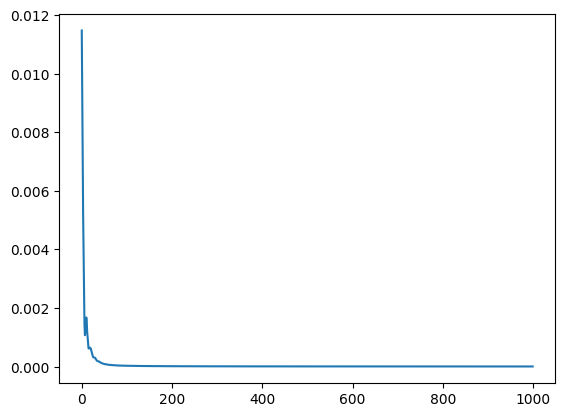

In [20]:
import matplotlib.pyplot as plt
plt.plot(lds_loss_values)

In [21]:
state_dim = 100 #@param
lds2 =  LDS(state_dim, d_model, d_model).to(device)
optimizer = torch.optim.Adam(lds2.parameters(), lr = 0.005)
lds_epochs = 1000
lds_loss_values2 = []

for epoch in range(lds_epochs):
    inputs = torch.randn(1, sl, d_model).to(device)
    stu_outputs = stu_layers[1](inputs)

    optimizer.zero_grad()
    loss = lds2.compute_loss(inputs, stu_outputs)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(lds2.parameters(), max_norm=1)
    lds_loss_values2.append(loss.item())
    optimizer.step()

    with torch.no_grad():
        lds2.A.data.clamp_(max=1, min = -1)

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.012472540140151978
Epoch 100, Loss: 2.2864671336719766e-05
Epoch 200, Loss: 1.2120936844439711e-05
Epoch 300, Loss: 9.178294931189157e-06
Epoch 400, Loss: 7.001323865551967e-06
Epoch 500, Loss: 6.299599590420257e-06
Epoch 600, Loss: 5.396408596425317e-06
Epoch 700, Loss: 5.619036528514698e-06
Epoch 800, Loss: 4.912671101919841e-06
Epoch 900, Loss: 5.09096526002395e-06


In [22]:
state_dim = 100 #@param
lds3 =  LDS(state_dim, d_model, d_model).to(device)
optimizer = torch.optim.Adam(lds3.parameters(), lr = 0.005)
lds_epochs = 1000
lds_loss_values3 = []

for epoch in range(lds_epochs):
    inputs = torch.randn(1, sl, d_model).to(device)
    stu_outputs = stu_layers[2](inputs)

    optimizer.zero_grad()
    loss = lds3.compute_loss(inputs, stu_outputs)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(lds3.parameters(), max_norm=1)
    lds_loss_values3.append(loss.item())
    optimizer.step()

    with torch.no_grad():
        lds3.A.data.clamp_(max=1, min = -1)

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.014044694602489471
Epoch 100, Loss: 3.7337333196774125e-05
Epoch 200, Loss: 1.831138251873199e-05
Epoch 300, Loss: 1.3111139196553268e-05
Epoch 400, Loss: 9.183905604004394e-06
Epoch 500, Loss: 6.680995284114033e-06
Epoch 600, Loss: 5.347592377802357e-06
Epoch 700, Loss: 5.2280997806519736e-06
Epoch 800, Loss: 4.6836007641104516e-06
Epoch 900, Loss: 4.790817456523655e-06


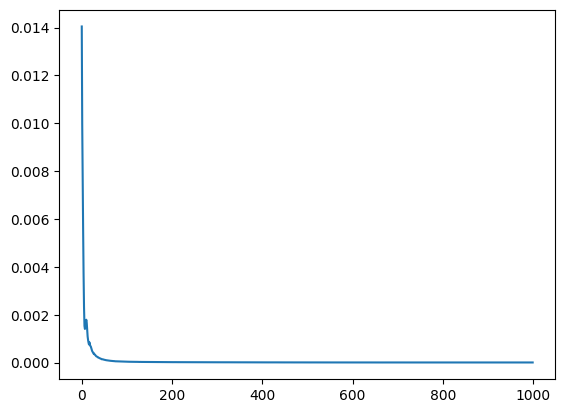

In [26]:
plt.plot(lds_loss_values3)

In [27]:
state_dim = 100 #@param
lds4 =  LDS(state_dim, d_model, d_model).to(device)
optimizer = torch.optim.Adam(lds4.parameters(), lr = 0.005)
lds_epochs = 1000
lds_loss_values4 = []

for epoch in range(lds_epochs):
    inputs = torch.randn(1, sl, d_model).to(device)
    stu_outputs = stu_layers[3](inputs)

    optimizer.zero_grad()
    loss = lds4.compute_loss(inputs, stu_outputs)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(lds4.parameters(), max_norm=1)
    lds_loss_values4.append(loss.item())
    optimizer.step()

    with torch.no_grad():
        lds4.A.data.clamp_(max=1, min = -1)

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.019592810422182083
Epoch 100, Loss: 4.230400372762233e-05
Epoch 200, Loss: 2.218291410827078e-05
Epoch 300, Loss: 1.553153560962528e-05
Epoch 400, Loss: 1.294273079111008e-05
Epoch 500, Loss: 1.1305008229101077e-05
Epoch 600, Loss: 8.866058124112897e-06
Epoch 700, Loss: 8.090549272310454e-06
Epoch 800, Loss: 7.62973832024727e-06
Epoch 900, Loss: 7.414897481794469e-06


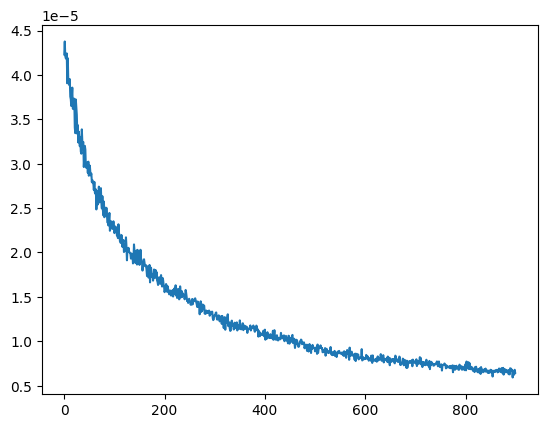

In [33]:
plt.plot(lds_loss_values4[100:])

In [34]:
model2 = copy.deepcopy(model)

model2.spectral_ssm['hidden'][0].stu = lds
model2.spectral_ssm['hidden'][1].stu = lds2
model2.spectral_ssm['hidden'][2].stu = lds3
model2.spectral_ssm['hidden'][3].stu = lds4
model2.to(device)

SpectralSSM(
  (loss_fn): Walker2DLoss(
    (mse_loss): MSELoss()
  )
  (spectral_ssm): ModuleDict(
    (dropout): Dropout(p=0.0, inplace=False)
    (hidden): ModuleList(
      (0-3): 4 x Block(
        (rn_1): RMSNorm(dim=32, eps=1e-05, elementwise_affine=True)
        (rn_2): RMSNorm(dim=32, eps=1e-05, elementwise_affine=True)
        (stu): LDS()
        (mlp): GatedMLP(
          (fc_1): Linear(in_features=32, out_features=256, bias=False)
          (fc_2): Linear(in_features=128, out_features=32, bias=False)
          (silu): SiLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
  (input_proj): Linear(in_features=24, out_features=32, bias=False)
  (output_proj): Linear(in_features=32, out_features=18, bias=False)
)

In [37]:
validation_loss = evaluate_model(model2, val_loader, loss_fn, device)
print(f"Validation Loss: {validation_loss:.4f}")    

100%|██████████| 703/703 [02:14<00:00,  5.23it/s]

Validation Loss: 0.7074


In [39]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [46]:
class Zero(nn.Module):
    def __init__(self):
        super(Zero, self).__init__()

    def forward(self, x):
        return torch.zeros(x.shape).to(device)

In [47]:
model3 = copy.deepcopy(model)

model3.spectral_ssm['hidden'][0].stu = Identity()
model3.spectral_ssm['hidden'][1].stu = Identity()
model3.spectral_ssm['hidden'][2].stu = Identity()
model3.spectral_ssm['hidden'][3].stu = Identity()
model3.to(device)

SpectralSSM(
  (loss_fn): Walker2DLoss(
    (mse_loss): MSELoss()
  )
  (spectral_ssm): ModuleDict(
    (dropout): Dropout(p=0.0, inplace=False)
    (hidden): ModuleList(
      (0-3): 4 x Block(
        (rn_1): RMSNorm(dim=32, eps=1e-05, elementwise_affine=True)
        (rn_2): RMSNorm(dim=32, eps=1e-05, elementwise_affine=True)
        (stu): Identity()
        (mlp): GatedMLP(
          (fc_1): Linear(in_features=32, out_features=256, bias=False)
          (fc_2): Linear(in_features=128, out_features=32, bias=False)
          (silu): SiLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
  (input_proj): Linear(in_features=24, out_features=32, bias=False)
  (output_proj): Linear(in_features=32, out_features=18, bias=False)
)

In [48]:
validation_loss = evaluate_model(model3, val_loader, loss_fn, device)
print(f"Validation Loss: {validation_loss:.4f}")    

100%|██████████| 703/703 [00:02<00:00, 263.70it/s]

Validation Loss: 5.8028


In [49]:
model3 = copy.deepcopy(model)

model3.spectral_ssm['hidden'][0].stu = Zero()
model3.spectral_ssm['hidden'][1].stu = Zero()
model3.spectral_ssm['hidden'][2].stu = Zero()
model3.spectral_ssm['hidden'][3].stu = Zero()
model3.to(device)

SpectralSSM(
  (loss_fn): Walker2DLoss(
    (mse_loss): MSELoss()
  )
  (spectral_ssm): ModuleDict(
    (dropout): Dropout(p=0.0, inplace=False)
    (hidden): ModuleList(
      (0-3): 4 x Block(
        (rn_1): RMSNorm(dim=32, eps=1e-05, elementwise_affine=True)
        (rn_2): RMSNorm(dim=32, eps=1e-05, elementwise_affine=True)
        (stu): Zero()
        (mlp): GatedMLP(
          (fc_1): Linear(in_features=32, out_features=256, bias=False)
          (fc_2): Linear(in_features=128, out_features=32, bias=False)
          (silu): SiLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
  (input_proj): Linear(in_features=24, out_features=32, bias=False)
  (output_proj): Linear(in_features=32, out_features=18, bias=False)
)

In [50]:
validation_loss = evaluate_model(model3, val_loader, loss_fn, device)
print(f"Validation Loss: {validation_loss:.4f}")    

100%|██████████| 703/703 [00:03<00:00, 230.49it/s]

Validation Loss: 0.7918


In [ ]:
validation_loss = evaluate_model(model3, val_loader, loss_fn, device)
print(f"Validation Loss: {validation_loss:.4f}")    

100%|██████████| 703/703 [00:03<00:00, 230.49it/s]

Validation Loss: 0.7918
